In [ ]:
%%capture
%pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate ipympl nussl pandas==1.5.2

In [31]:
import torch
import matplotlib.pyplot as plt


from src import LatentDiffusionConditional, LatentDiffusion, AutoencoderKL, Autoencoder
from dataset import SpectrogramDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [ ]:
test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=3
                           )

condition, target = test_ds[0]

plt.subplot(1,2,1)
plt.imshow(condition.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(target.permute(1,2,0))

### Model

In [ ]:
autoencoder = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
pl_ae_model = Autoencoder(autoencoder).to(device)

In [ ]:
model_path = 'trained_models/mask_latent_diffusion/lightning_logs/version_1/'
model = LatentDiffusionConditional.load_from_checkpoint(model_path + 'checkpoints/epoch=1523-step=48768.ckpt', train_dataset = test_ds, autoencoder = pl_ae_model).to(device)


### Create plots


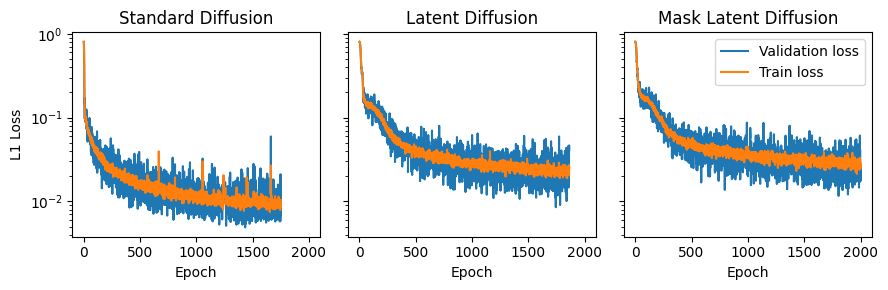

In [62]:
import pandas as pd
import os
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


model_path_1='/notebooks/trained_models/diffusion/L1/lightning_logs'
model_path_2='/notebooks/trained_models/latent_diffusion/L1/lightning_logs'
model_path_3='/notebooks/trained_models/mask_latent_diffusion/L1/lightning_logs'

model_paths = [model_path_1, model_path_2, model_path_3]

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(9,3))


for model in range(len(model_paths)):

    summary_iterators = [EventAccumulator(os.path.join(model_paths[model], dname)).Reload() for dname in os.listdir(model_paths[model])]


    tags = summary_iterators[0].Tags()['scalars']

    valsteps = []
    valvalues = []
    trainsteps = []
    trainvalues = []

    for ver in summary_iterators:
        if all(tag in ver.Tags()['scalars'] for tag in tags):
            valsteps.extend([e.step/63 for e in ver.Scalars('val_loss')])
            valvalues.extend([e.value for e in ver.Scalars('val_loss')])
            trainsteps.extend([e.step/63 for e in ver.Scalars('val_loss')])
            trainvalues.extend([e.value for e in ver.Scalars('train_loss')])

    valsteps,valvalues = zip(*sorted(zip(valsteps,valvalues)))
    trainsteps,trainvalues = zip(*sorted(zip(trainsteps,trainvalues)))

    axs[model].plot(valsteps,valvalues, label='Validation loss')
    axs[model].plot(trainsteps,trainvalues, label='Train loss')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='L1 Loss')
    ax.set_yscale('log')
    ax.label_outer()

axs[0].set_title('Standard Diffusion')
axs[1].set_title('Latent Diffusion')
axs[2].set_title('Mask Latent Diffusion')
    
plt.legend()
plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
import os
import json
import glob
import numpy as np
import nussl
import nussl.evaluation as ne


outputs = []
targets = []

for i in range(2):
    mix = test_ds[i][0]
    out = model(mix.unsqueeze(0), verbose=True).detach().cpu()
    out = out[0]
    phase = test_ds.get_phase(i)

    estimated_source = out * test_ds[i][0]
    target_source = test_ds[i][1]

    mix = nussl.AudioSignal(audio_data_array=test_ds.to_audio(mix, phase), sample_rate=11025)
    estimated_source = nussl.AudioSignal(audio_data_array=test_ds.to_audio(estimated_source, phase), sample_rate=11025)
    target_source = nussl.AudioSignal(audio_data_array=test_ds.to_audio(target_source, phase), sample_rate=11025)

    target_rest = mix - target_source
    estimated_rest = mix - estimated_source

    estimates = [estimated_source, estimated_rest]
    targets = [target_source, target_rest]

    evaluator = ne.BSSEvalScale(targets, estimates, ['ins3', 'rest'])
    scores = evaluator.evaluate()

    os.makedirs(model_path + 'scores/', exist_ok=True)
    output_file = model_path + 'scores/' + test_ds.files[i].replace('wav', 'json')
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)

In [ ]:
import pandas as pd
json_files = glob.glob(str(model_path) + 'scores/*.json')

df = ne.aggregate_score_files(json_files, aggregator=np.nanmedian)
report_card = ne.report_card(df, report_each_source=True)
print(report_card)
with open(model_path + 'report_card.json', 'w') as f:
    json.dump(report_card, f, indent=4)